In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
df = pd.read_csv("ta125_2012_2020.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,02/01/2012,990.869995,1001.330017,989.630005,1000.270020,1000.270020,0.0
1,03/01/2012,1004.250000,1009.520020,1000.809998,1004.190002,1004.190002,303840800.0
2,04/01/2012,1003.049988,1008.200012,1001.010010,1005.700012,1005.700012,192298000.0
3,05/01/2012,1005.739990,1010.500000,999.080017,1006.760010,1006.760010,436324600.0
4,08/01/2012,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226 entries, 0 to 2225
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2226 non-null   object 
 1   Open       1749 non-null   float64
 2   High       1749 non-null   float64
 3   Low        1749 non-null   float64
 4   Close      1749 non-null   float64
 5   Adj Close  1749 non-null   float64
 6   Volume     1749 non-null   float64
dtypes: float64(6), object(1)
memory usage: 121.9+ KB


In [5]:
df = df.fillna(method='ffill')

In [6]:
df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)

In [7]:
df.head()

,Date,Adj Close
0,02/01/2012,1000.270020
1,03/01/2012,1004.190002
2,04/01/2012,1005.700012
3,05/01/2012,1006.760010
4,08/01/2012,1006.760010


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226 entries, 0 to 2225
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2226 non-null   object 
 1   Adj Close  2226 non-null   float64
dtypes: float64(1), object(1)
memory usage: 34.9+ KB


In [9]:
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
df = df.set_index(['Date'], drop=True)

In [11]:
df.head(5)

,Adj Close
Date,
2012-02-01,1000.270020
2012-03-01,1004.190002
2012-04-01,1005.700012
2012-05-01,1006.760010
2012-08-01,1006.760010


In [12]:
df.tail(5)

,Adj Close
Date,
2020-12-20,1534.670044
2020-12-21,1488.599976
2020-12-22,1506.189941
2020-12-23,1509.150024
2020-12-24,1528.869995


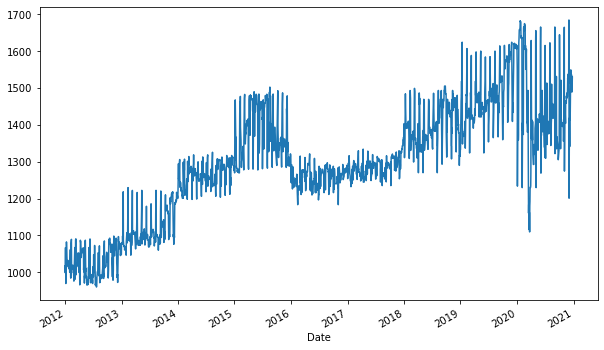

In [13]:
# df = df.sort_index()
plt.figure(figsize=(10, 6))
df['Adj Close'].plot();

In [14]:
split_date = pd.Timestamp('2020-01-01')

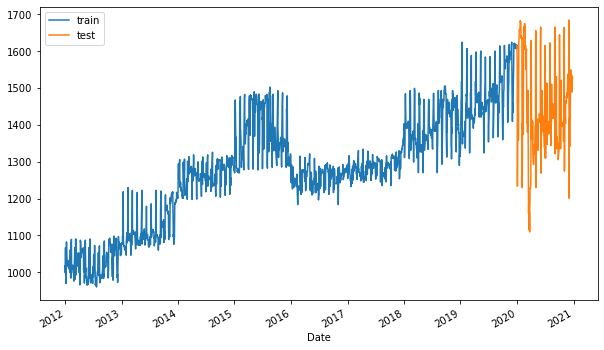

In [15]:
df =  df['Adj Close']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);

In [16]:
train = train.to_numpy()
test = test.to_numpy()

In [17]:
train = train.reshape(-1,1)
test = test.reshape(-1,1)

In [18]:
# scale train and test data to [-1, 1]
scaler = MinMaxScaler()
train_sc = scaler.fit_transform(train)
test_sc = scaler.transform(test)

In [19]:
train_sc

array([[0.06016346],
       [0.06607275],
       [0.06834905],
       ...,
       [0.97272979],
       [0.98679449],
       [0.98679449]])

In [20]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'])
test_sc_df = pd.DataFrame(test_sc, columns=['Y'])

In [21]:
for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

In [22]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [23]:
X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('Train shape: ', X_train_lmse.shape)
print('Test shape: ', X_test_lmse.shape)

Train shape:  (1983, 1, 1)
Test shape:  (242, 1, 1)


In [24]:
lstm_model = Sequential()
lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
1983/1983 [==============================] - 3s 1ms/step - loss: 4.7484e-04
Epoch 2/100
1983/1983 [==============================] - 3s 2ms/step - loss: 9.5690e-04
Epoch 3/100
1983/1983 [==============================] - 3s 1ms/step - loss: 3.5932e-04
Epoch 4/100
1983/1983 [==============================] - 2s 1ms/step - loss: 2.4017e-04
Epoch 5/100
1983/1983 [==============================] - 2s 1ms/step - loss: 2.1737e-04
Epoch 6/100
1983/1983 [==============================] - 2s 1ms/step - loss: 2.1173e-04
Epoch 7/100
1983/1983 [==============================] - 2s 1ms/step - loss: 2.0994e-04
Epoch 8/100
1983/1983 [==============================] - 2s 1ms/step - loss: 2.0928e-04
Epoch 9/100
1983/1983 [==============================] - 2s 1ms/step - loss: 2.0900e-04
Epoch 10/100
1983/1983 [==============================] - 2s 1ms/step - loss: 2.0888e-04
Epoch 11/100
1983/1983 [==============================] - 2s 1ms/step - loss: 2.0882e-04
Epoch 12/100
1983/1983 [======

In [25]:
y_pred_test = lstm_model.predict(X_test_lmse)
y_pred_train = lstm_model.predict(X_train_lmse)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_pred_train)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test)))

The R2 score on the Train set is:	0.980
The R2 score on the Test set is:	0.939


In [26]:
from sklearn.metrics import mean_squared_error
lin_mse_train = mean_squared_error(y_pred_train, y_train)
lin_rmse_train = np.sqrt(lin_mse_train)
lin_mse_test = mean_squared_error(y_pred_test, y_test)
lin_rmse_test = np.sqrt(lin_mse_test)
print("The RMSE on the Train set is:\t{:0.3f}".format(lin_rmse_train))
print("The RMSE on the Test set is:\t{:0.3f}".format(lin_rmse_test))

The RMSE on the Train set is:	0.031
The RMSE on the Test set is:	0.045


In [27]:
from sklearn.metrics import mean_absolute_error
lin_mae_train = mean_squared_error(y_pred_train, y_train)
lin_mae_test = mean_squared_error(y_pred_test, y_test)
print("The MAE on the Train set is:\t{:0.3f}".format(lin_mae_train))
print("The MAE on the Test set is:\t{:0.3f}".format(lin_mae_test))

The MAE on the Train set is:	0.001
The MAE on the Test set is:	0.002


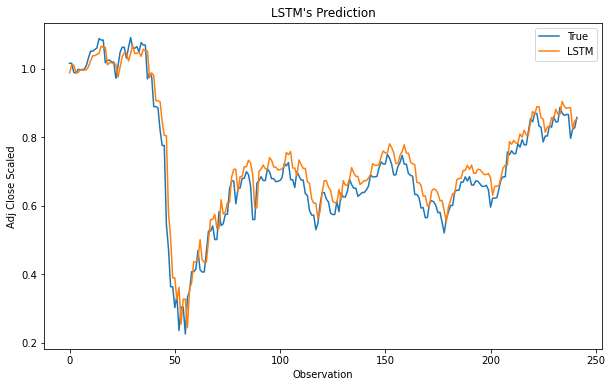

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred_test, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Adj Close Scaled')
plt.legend()
plt.show();